In [1]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############
from collections import OrderedDict
import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import sqrt
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
#from macro_sql import Q076 
with open('quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [7]:
#load single bank data as dataframe
bank_df = pd.read_csv('dist_csvs/income_to_amount_dist__bank.csv')
inc_df = bank_df.copy() # split income df out to sort values by income for graphing cumulative income percent
#these data are for single family, conventional, owner occupied, first lien, home purchase loans at the national level
#other analysis will be used for each loan product, lien status, geography, and other variables as appropriate

In [8]:
#sort data frame by amount field, this is useful because multiple years are present
bank_df.sort_values(by='amount', inplace=True)
inc_df.sort_values(by='income', inplace=True)
inc_df.head()

,year,income,amount
0,2014,1,88
229447,2011,1,10
156483,2012,1,50
76159,2013,1,8
76160,2013,1,16


In [9]:
#bank_df = bank_df[bank_df.year == 2014].copy() #select single year
bank_df.income = bank_df.income.map(int) #convert data to numeric
bank_df.amount = bank_df.amount.map(int) #convert data to numeric
bank_df['mult'] = bank_df.amount/bank_df.income #create amount to income multiple

#create percent and cumulative percents by value
bank_df['pct_amt'] = bank_df['amount']/bank_df['amount'].sum() #calculate percent of total amount for each row
bank_df['cumul_amt_pct'] = bank_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
bank_df['pct_inc'] = bank_df['income']/bank_df['income'].sum()
bank_df['cumul_inc_pct'] = bank_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
cnt_amt_df = pd.DataFrame(bank_df.groupby(['amount']).pct_amt.count())
cnt_amt_df.rename(columns={'pct_amt':'count_amt'}, inplace=True)
cnt_amt_df['amount'] = cnt_amt_df.index
cnt_amt_df['pct_of_cnt'] = cnt_amt_df.count_amt.divide(other=cnt_amt_df.count_amt.sum())
cnt_amt_df['cumul_pct_cnt'] = cnt_amt_df.pct_of_cnt.cumsum()

#create percent and cumulative percents by value
inc_df['pct_amt'] = inc_df['amount']/inc_df['amount'].sum() #calculate percent of total amount for each row
inc_df['cumul_amt_pct'] = inc_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
inc_df['pct_inc'] = inc_df['income']/inc_df['income'].sum()
inc_df['cumul_inc_pct'] = inc_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
total = inc_df.groupby(['income']).pct_inc.count().sum()

#create percent and cumulative percents by count and count times amount
cnt_inc_df = pd.DataFrame(inc_df.groupby(['income']).pct_inc.count())
cnt_inc_df.rename(columns={'pct_inc':'count_inc'}, inplace=True)
cnt_inc_df['income'] = cnt_inc_df.index
cnt_inc_df['pct_of_cnt'] = cnt_inc_df.count_inc.divide(other=cnt_inc_df.count_inc.sum())
cnt_inc_df['cumul_pct_cnt'] = cnt_inc_df.pct_of_cnt.cumsum()



400.963857957 std
442.363262216 mean
338.0 median
2500.0 max mult
0.00314465408805 min mult
1600.0 98%
559.0 q3
199.0 q1
48.0 02%
360.0 iqr
-341.0 min_q 1099.0 max_q


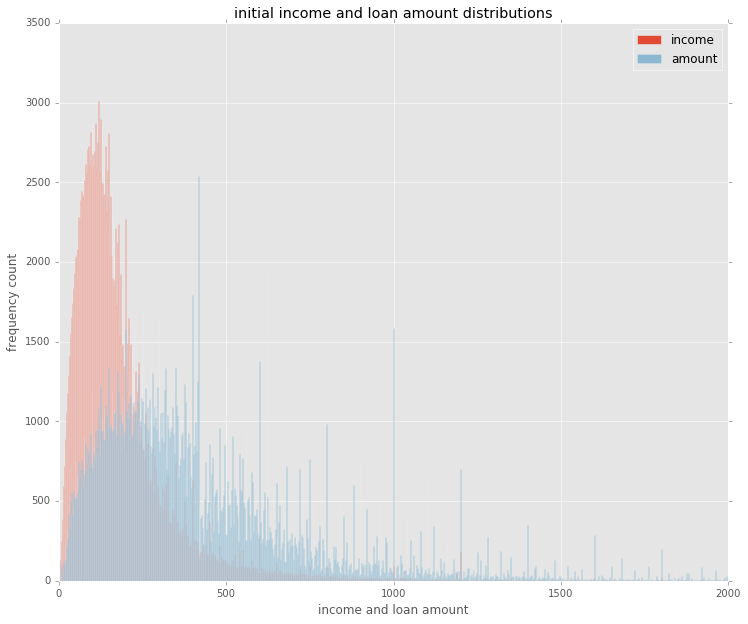

In [10]:
#calculate descriptive stats
print(bank_df.amount.std(), 'std') 
print(bank_df.amount.mean(), 'mean') 
print(bank_df.amount.median(), 'median')
print(bank_df.mult.max(), 'max mult')
print(bank_df.mult.min(), 'min mult')
print(bank_df.amount.quantile(q=.98), '98%')
print(bank_df.amount.quantile(q=.75), 'q3')
print(bank_df.amount.quantile(q=.25), 'q1')
print(bank_df.amount.quantile(q=.02), '02%')
q1 = bank_df.amount.quantile(q=.25)
q3 = bank_df.amount.quantile(q=.75)
q98 = bank_df.amount.quantile(q=.98) #potential upper bound for quality
q2 = bank_df.amount.quantile(q=.02) #potential lower bound for quality
iqr =(q3 - q1)
print(iqr, 'iqr')
min_q = q1 - 1.5 * iqr #potential lower bound for quality
max_q = q3 + 1.5 * iqr #potential upper bound for quality
print(min_q, 'min_q', max_q, 'max_q')


amt = bank_df.amount #get data as series for graphing
inc = bank_df.income #get data as series for graphing
bins = np.linspace(0,2000, 1000) #set ranges and number of bins
bank_viz = plt.figure(figsize=(12,10)) #set plot size
plt.hist(inc, bins, label='income', alpha=1) #plot histogram of income
plt.hist(amt, bins, label='amount', alpha=.5) #plot histogram of loan amount
plt.legend(loc='upper right') #turn on legend and set location
plt.title('initial income and loan amount distributions')
plt.xlabel('income and loan amount')
plt.ylabel('frequency count')
plt.show()
#FIXME add 2 box plot viz

name 0 to 10
std 81.1996340482
mean 116.188741722
median 95.0
max_mult 361.0
min_mult 0.25
q98 331.28
q02 14.06
q75 160.0
q25 51.75
iqr 108.25
min_q -110.625
max_q 322.375
count of loans 604
pct of total loans 0.221977474912


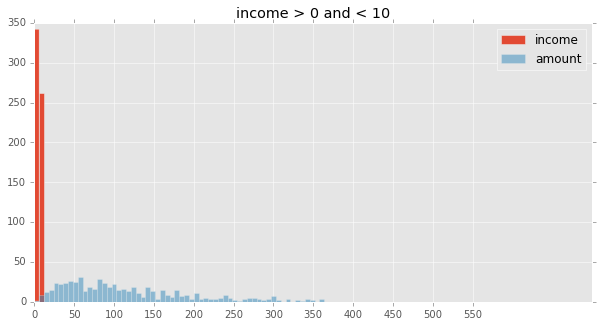

name 10 to 30
std 49.3154892419
mean 89.1957720588
median 81.0
max_mult 22.5
min_mult 0.0526315789474
q98 215.7
q02 18.0
q75 120.0
q25 50.0
iqr 70.0
min_q -55.0
max_q 225.0
count of loans 7616
pct of total loans 2.7534072349


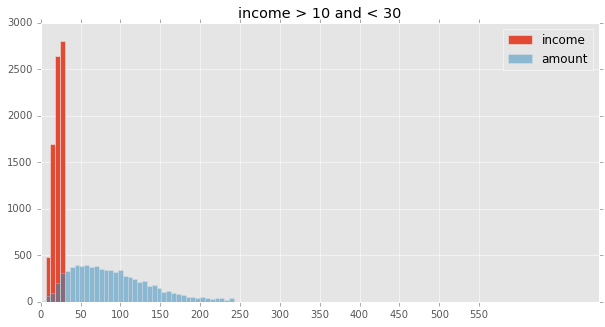

name 30 to 50
std 69.737003982
mean 134.422952854
median 129.0
max_mult 11.4666666667
min_mult 0.030303030303
q98 289.0
q02 24.0
q75 183.0
q25 78.0
iqr 105.0
min_q -79.5
max_q 340.5
count of loans 16120
pct of total loans 5.60774432014


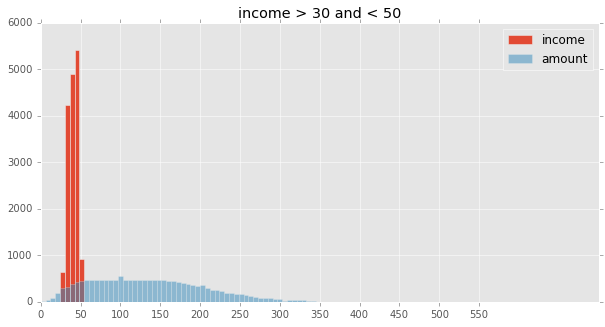

name 50 to 70
std 91.9202442601
mean 184.747029408
median 179.0
max_mult 9.0
min_mult 0.0645161290323
q98 380.0
q02 35.0
q75 252.0
q25 110.0
iqr 142.0
min_q -103.0
max_q 465.0
count of loans 21797
pct of total loans 7.50222488944


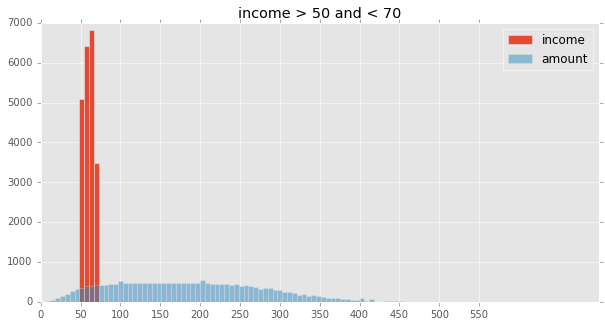

name 70 to 90
std 109.983707715
mean 228.85617799
median 222.0
max_mult 7.83098591549
min_mult 0.0958904109589
q98 464.0
q02 45.0
q75 309.0
q25 141.0
iqr 168.0
min_q -111.0
max_q 561.0
count of loans 25170
pct of total loans 8.6404135396


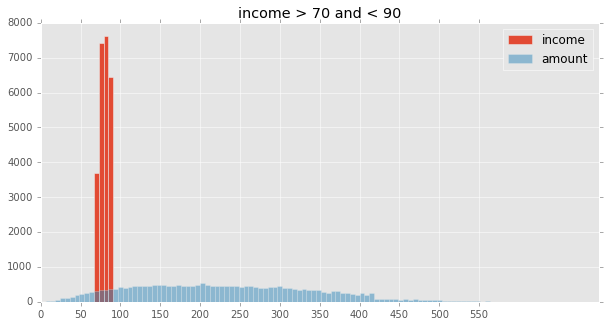

name 90 to 110
std 127.434787735
mean 268.718684682
median 259.0
max_mult 6.95555555556
min_mult 0.0747663551402
q98 548.18
q02 56.0
q75 356.0
q25 168.0
iqr 188.0
min_q -114.0
max_q 638.0
count of loans 26792
pct of total loans 9.19348184115


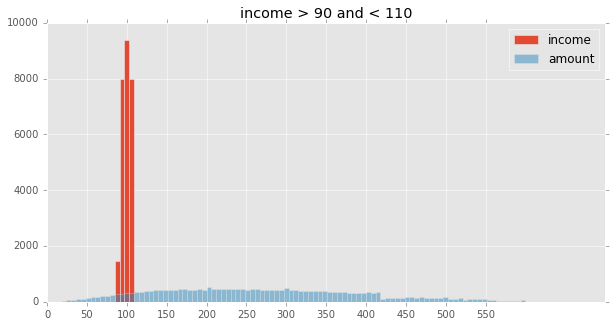

name 110 to 130
std 143.157154582
mean 309.861331727
median 296.0
max_mult 6.4
min_mult 0.0545454545455
q98 624.0
q02 70.0
q75 401.0
q25 199.0
iqr 202.0
min_q -104.0
max_q 704.0
count of loans 26567
pct of total loans 9.13994810296


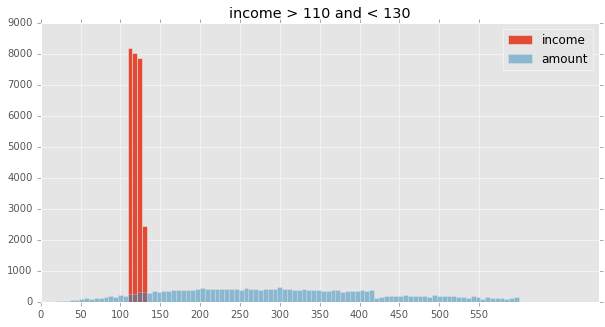

name 130 to 150
std 157.991380351
mean 348.409233272
median 330.0
max_mult 6.10687022901
min_mult 0.0555555555556
q98 700.0
q02 85.0
q75 457.0
q25 229.0
iqr 228.0
min_q -113.0
max_q 799.0
count of loans 24585
pct of total loans 8.44810125719


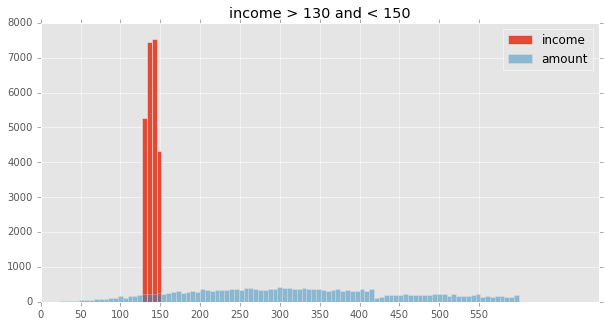

name 150 to 170
std 173.329074729
mean 385.282968324
median 362.0
max_mult 5.86666666667
min_mult 0.0533333333333
q98 780.0
q02 97.0
q75 504.0
q25 256.0
iqr 248.0
min_q -116.0
max_q 876.0
count of loans 21278
pct of total loans 7.34946619702


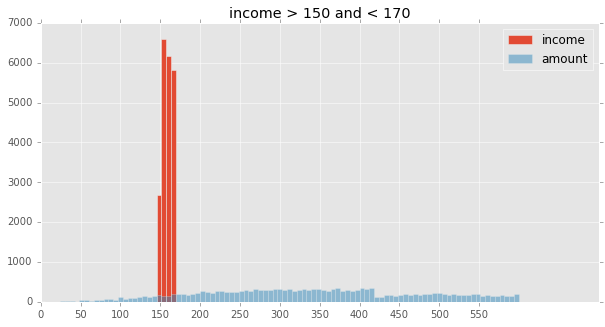

name 170 to 190
std 187.177099026
mean 422.277378052
median 393.0
max_mult 5.64705882353
min_mult 0.0454545454545
q98 872.0
q02 112.0
q75 548.0
q25 283.0
iqr 265.0
min_q -114.5
max_q 945.5
count of loans 17651
pct of total loans 6.11205259264


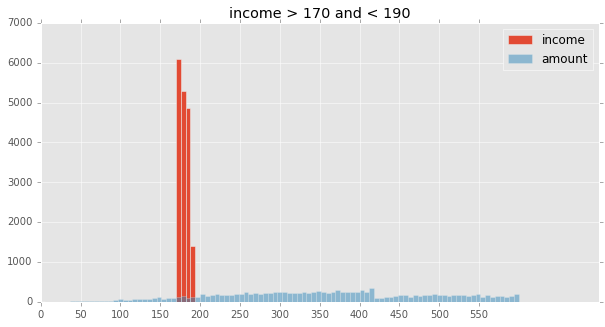

name 190 to 210
std 205.091933236
mean 461.036165636
median 430.0
max_mult 5.49214659686
min_mult 0.0384615384615
q98 950.0
q02 121.0
q75 597.0
q25 308.0
iqr 289.0
min_q -125.5
max_q 1030.5
count of loans 14876
pct of total loans 5.16719916256


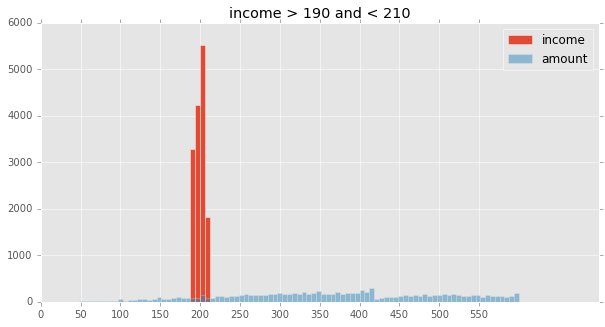

name 210 to 230
std 223.469247
mean 505.654136546
median 484.0
max_mult 5.32380952381
min_mult 0.134529147982
q98 1031.02
q02 132.0
q75 644.0
q25 336.0
iqr 308.0
min_q -126.0
max_q 1106.0
count of loans 12450
pct of total loans 4.32054774903


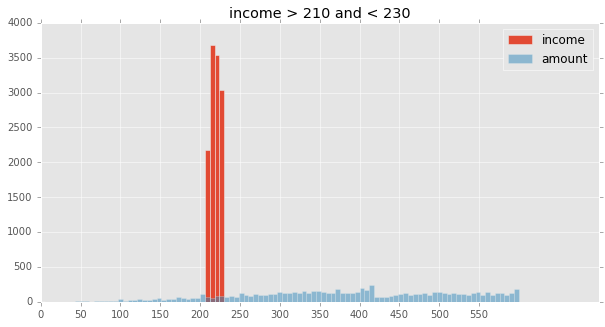

name 230 to 250
std 239.112766938
mean 544.601783061
median 525.0
max_mult 5.26956521739
min_mult 0.127659574468
q98 1100.0
q02 141.0
q75 695.0
q25 364.0
iqr 331.0
min_q -132.5
max_q 1191.5
count of loans 10095
pct of total loans 3.51174502938


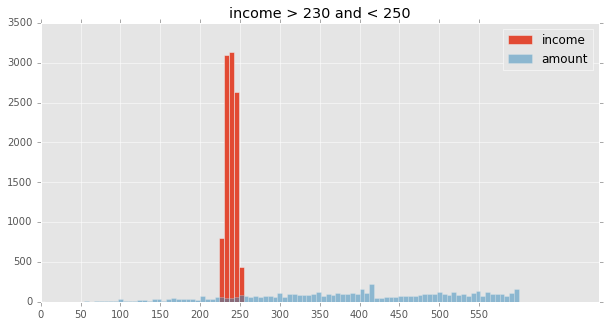

name 250 to 270
std 259.53739747
mean 586.86962963
median 563.0
max_mult 5.2
min_mult 0.0965250965251
q98 1197.04
q02 150.0
q75 744.0
q25 389.0
iqr 355.0
min_q -143.5
max_q 1276.5
count of loans 8775
pct of total loans 3.05653776515


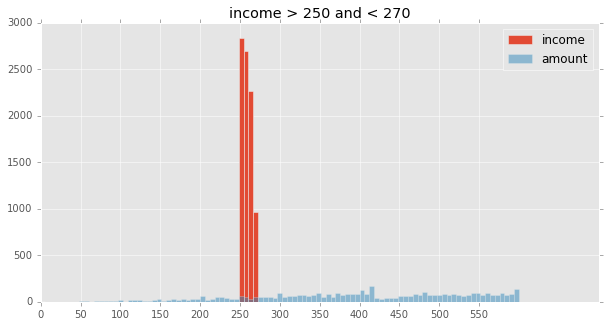

name 270 to 290
std 288.525607404
mean 632.209619526
median 600.0
max_mult 5.37777777778
min_mult 0.0280701754386
q98 1312.72
q02 160.0
q75 808.0
q25 411.0
iqr 397.0
min_q -184.5
max_q 1403.5
count of loans 6965
pct of total loans 2.41447388611


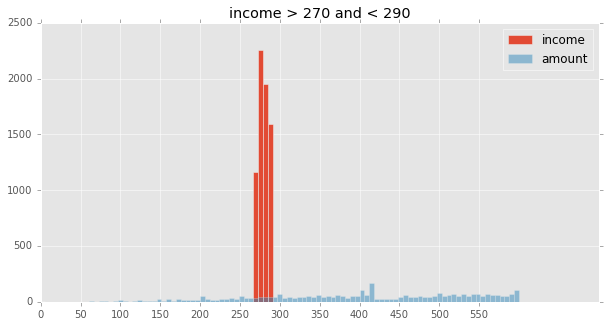

name 290 to 310
std 315.790798606
mean 681.35610631
median 640.0
max_mult 5.46206896552
min_mult 0.0271186440678
q98 1405.44
q02 160.0
q75 890.0
q25 430.0
iqr 460.0
min_q -260.0
max_q 1580.0
count of loans 6133
pct of total loans 2.11611706499


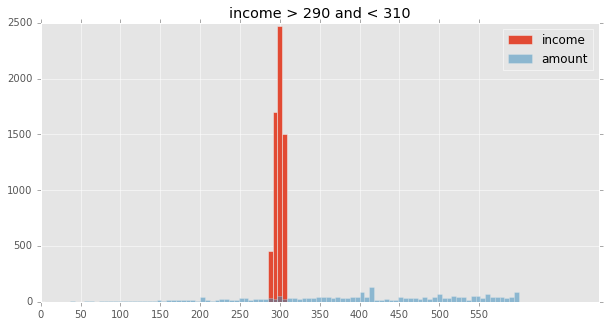

name 310 to 330
std 324.880575518
mean 713.694929006
median 673.5
max_mult 5.20382165605
min_mult 0.0253968253968
q98 1461.42
q02 175.0
q75 934.75
q25 470.25
iqr 464.5
min_q -226.5
max_q 1631.5
count of loans 4930
pct of total loans 1.7066010168


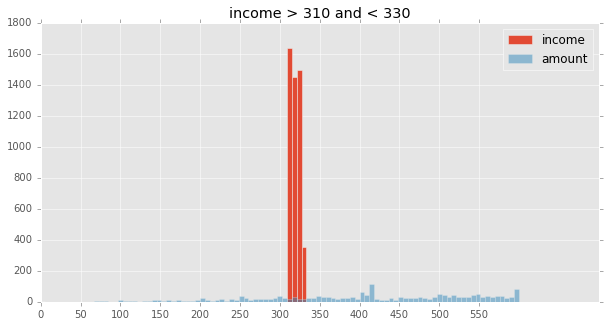

name 330 to 350
std 342.332723278
mean 748.83641897
median 700.0
max_mult 5.22727272727
min_mult 0.14450867052
q98 1550.0
q02 188.0
q75 988.5
q25 490.0
iqr 498.5
min_q -257.75
max_q 1736.25
count of loans 3943
pct of total loans 1.36800864723


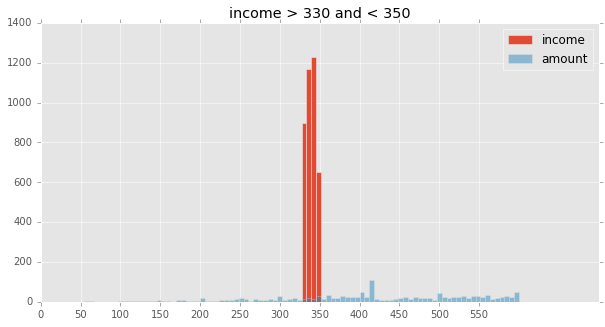

name 350 to 370
std 360.202161236
mean 767.007460698
median 719.0
max_mult 5.12285714286
min_mult 0.139275766017
q98 1599.84
q02 164.0
q75 1000.0
q25 500.0
iqr 500.0
min_q -250.0
max_q 1750.0
count of loans 3753
pct of total loans 1.30424553232


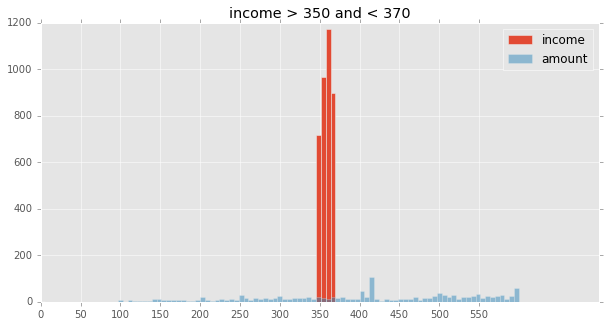

name 370 to 390
std 390.858347911
mean 814.103287944
median 750.0
max_mult 5.14745308311
min_mult 0.0616966580977
q98 1738.4
q02 192.0
q75 1079.0
q25 520.0
iqr 559.0
min_q -318.5
max_q 1917.5
count of loans 3011
pct of total loans 1.03964565439


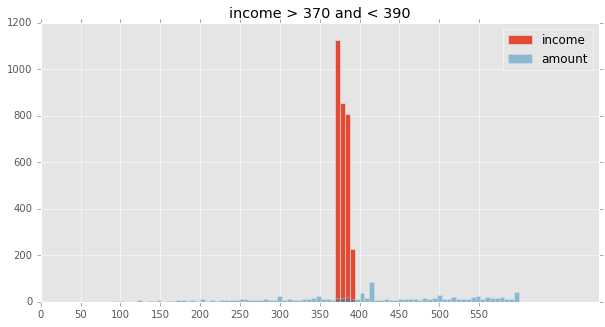

name 390 to 410
std 415.384851123
mean 843.214545455
median 780.0
max_mult 5.12820512821
min_mult 0.05
q98 1840.0
q02 199.98
q75 1106.75
q25 530.0
iqr 576.75
min_q -335.125
max_q 1971.875
count of loans 2750
pct of total loans 0.944171471632


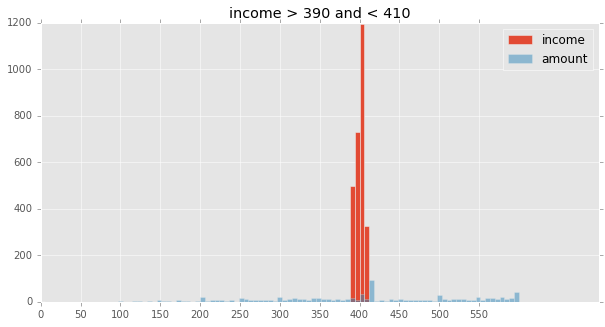

name 410 to 430
std 435.435233835
mean 890.18744313
median 828.0
max_mult 4.94202898551
min_mult 0.0571428571429
q98 1940.06
q02 203.76
q75 1187.75
q25 560.0
iqr 627.75
min_q -381.625
max_q 2129.375
count of loans 2198
pct of total loans 0.752200168444


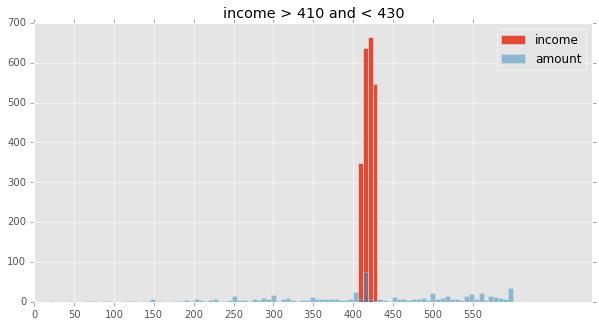

name 430 to 450
std 448.908144186
mean 899.48807543
median 852.0
max_mult 4.75892857143
min_mult 0.0925925925926
q98 1994.4
q02 187.12
q75 1196.0
q25 544.0
iqr 652.0
min_q -434.0
max_q 2174.0
count of loans 1803
pct of total loans 0.619559250255


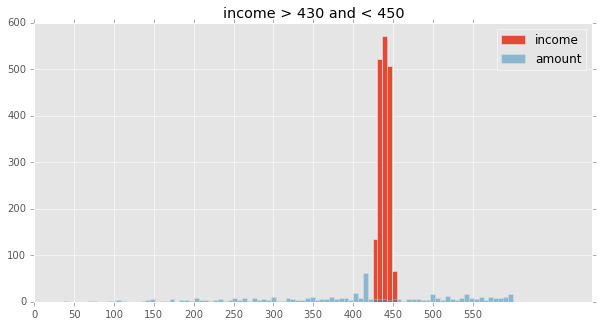

name 450 to 470
std 459.13692831
mean 918.680787589
median 860.0
max_mult 4.85651214128
min_mult 0.0789473684211
q98 1995.5
q02 200.0
q75 1229.0
q25 574.75
iqr 654.25
min_q -406.625
max_q 2210.375
count of loans 1676
pct of total loans 0.575231951117


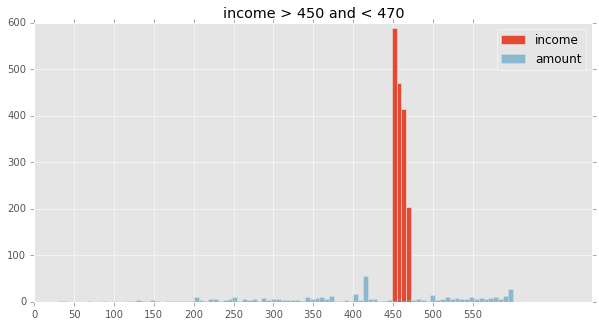

name 470 to 490
std 482.409236945
mean 950.813432836
median 888.0
max_mult 4.87949260042
min_mult 0.145833333333
q98 2000.0
q02 186.76
q75 1280.0
q25 576.5
iqr 703.5
min_q -478.75
max_q 2335.25
count of loans 1474
pct of total loans 0.50703610629


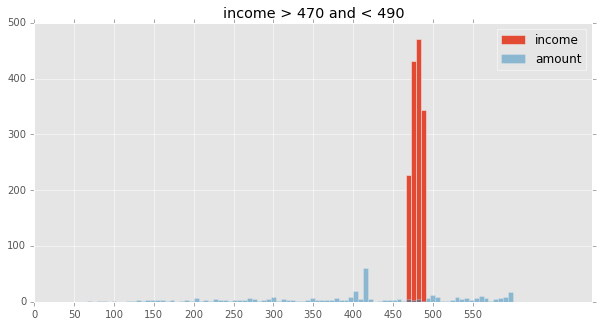

name 490 to 510
std 499.705310497
mean 958.988111888
median 896.0
max_mult 4.92525252525
min_mult 0.05
q98 2000.0
q02 195.0
q75 1320.0
q25 575.0
iqr 745.0
min_q -542.5
max_q 2437.5
count of loans 1430
pct of total loans 0.491692041204


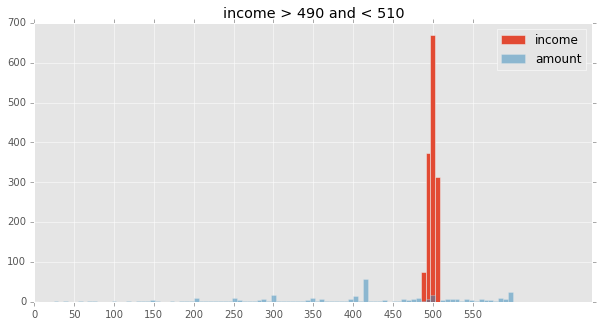

name 510 to 530
std 479.527432656
mean 992.931398417
median 954.0
max_mult 4.625
min_mult 0.0896946564885
q98 2000.0
q02 212.64
q75 1320.0
q25 626.0
iqr 694.0
min_q -415.0
max_q 2361.0
count of loans 1137
pct of total loans 0.393149045429


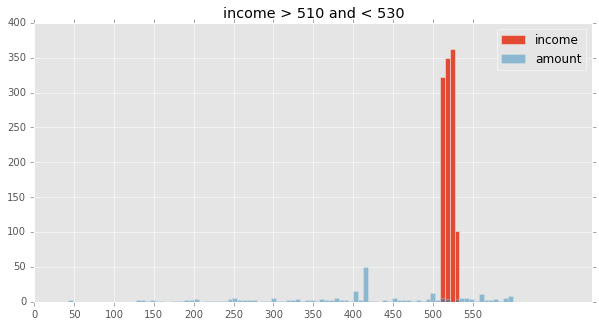

name 530 to 550
std 516.19878709
mean 972.407300672
median 911.0
max_mult 4.61393596987
min_mult 0.103825136612
q98 2000.0
q02 193.6
q75 1300.0
q25 567.0
iqr 733.0
min_q -532.5
max_q 2399.5
count of loans 1041
pct of total loans 0.359392102239


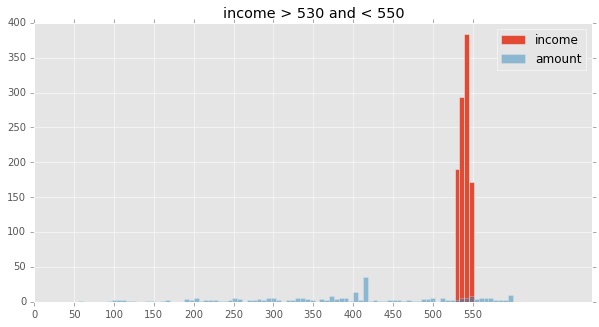

name 550 to 570
std 500.724213273
mean 1005.21253985
median 960.0
max_mult 4.45454545455
min_mult 0.127433628319
q98 2000.0
q02 200.0
q75 1348.0
q25 625.0
iqr 723.0
min_q -459.5
max_q 2432.5
count of loans 941
pct of total loans 0.32563515905


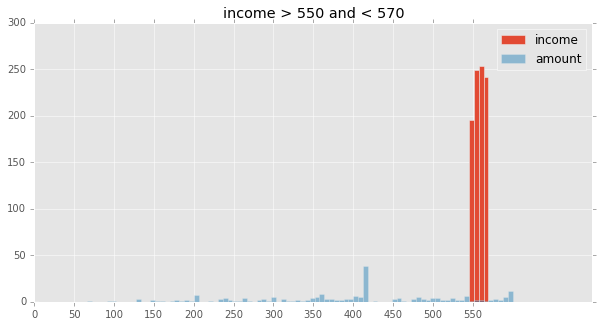

name 570 to 590
std 512.831919023
mean 1041.84029484
median 987.0
max_mult 4.375
min_mult 0.0557491289199
q98 2104.44
q02 253.04
q75 1398.0
q25 626.5
iqr 771.5
min_q -530.75
max_q 2555.25
count of loans 814
pct of total loans 0.280966880688


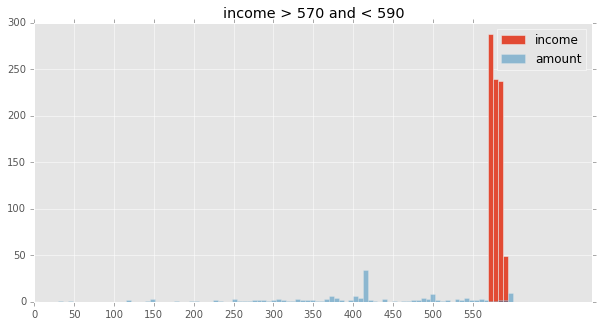

name 590 to 610
std 565.644802394
mean 1086.10428737
median 1000.0
max_mult 4.51559934319
min_mult 0.0833333333333
q98 2294.96
q02 167.84
q75 1480.0
q25 631.0
iqr 849.0
min_q -642.5
max_q 2753.5
count of loans 863
pct of total loans 0.296992904222


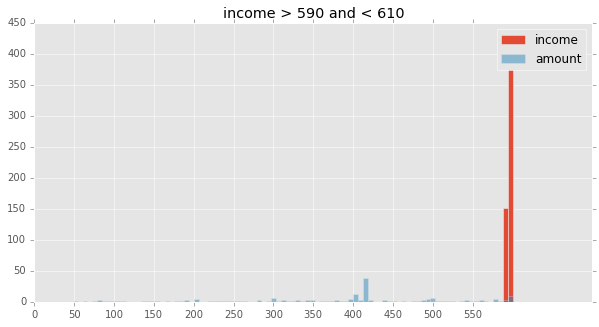

name 610 to 630
std 572.039536019
mean 1084.0
median 1025.0
max_mult 4.44711538462
min_mult 0.0780487804878
q98 2458.52
q02 166.48
q75 1497.5
q25 628.5
iqr 869.0
min_q -675.0
max_q 2801.0
count of loans 599
pct of total loans 0.205610472154


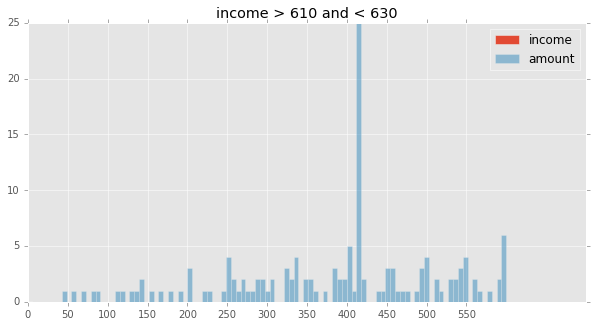

name 630 to 650
std 553.146624921
mean 1097.17331023
median 1048.0
max_mult 4.1856474259
min_mult 0.0283018867925
q98 2157.36
q02 197.12
q75 1500.0
q25 640.0
iqr 860.0
min_q -650.0
max_q 2790.0
count of loans 577
pct of total loans 0.198790887671


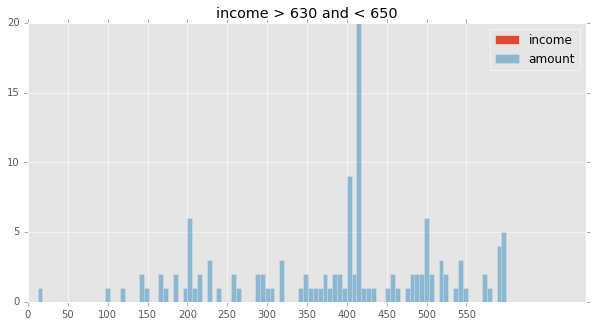

name 650 to 670
std 567.554386327
mean 1089.2626087
median 1000.0
max_mult 4.18569254186
min_mult 0.113636363636
q98 2259.88
q02 205.28
q75 1480.0
q25 637.5
iqr 842.5
min_q -626.25
max_q 2743.75
count of loans 575
pct of total loans 0.199472846119


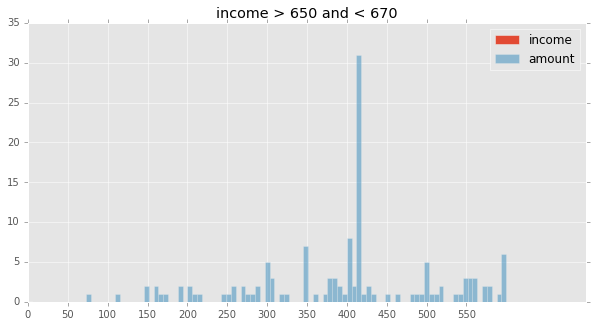

name 670 to 690
std 562.605590827
mean 1133.40039448
median 1095.0
max_mult 4.08759124088
min_mult 0.0845481049563
q98 2243.24
q02 190.32
q75 1526.5
q25 693.5
iqr 833.0
min_q -556.0
max_q 2776.0
count of loans 507
pct of total loans 0.175263321206


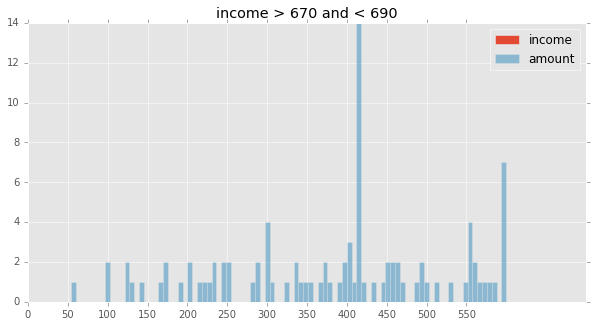

name 690 to 710
std 603.947331011
mean 1124.28143713
median 1042.0
max_mult 4.09798270893
min_mult 0.10071942446
q98 2560.0
q02 200.0
q75 1503.0
q25 636.0
iqr 867.0
min_q -664.5
max_q 2803.5
count of loans 501
pct of total loans 0.171853528964


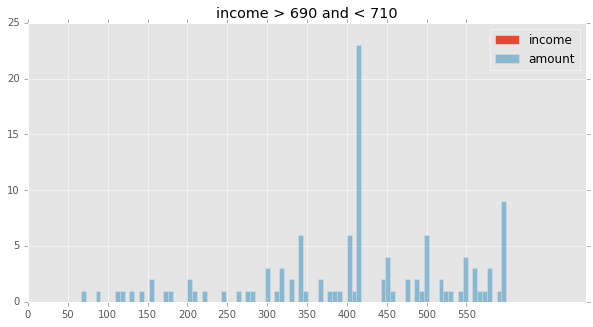

name 710 to 730
std 617.544057492
mean 1109.6804878
median 1026.0
max_mult 4.08333333333
min_mult 0.0208333333333
q98 2497.3
q02 141.8
q75 1512.0
q25 609.75
iqr 902.25
min_q -743.625
max_q 2865.375
count of loans 410
pct of total loans 0.141165398792


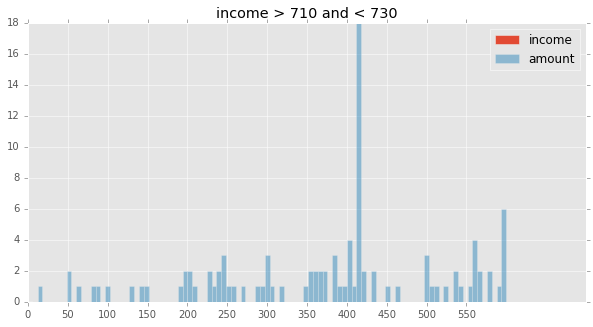

In [49]:
#Cycle over different income bins and plot loan amount distribution for each
#focus on finding the best bins
#repeat for different SQL selection filters (junior liens, non-owner-occupied, VA/FHA/RHS loans, manufactured housing)
bin_min = 0
bin_max = 10
bin_step = 20
pct_of_loans = OrderedDict({})
first = True
while bin_max < 750:#bank_df.income.max():
    graph_bin = bank_df[(bank_df.income >=bin_min) & (bank_df.income < bin_max)] #create bin of of amount for selected income
    #set descriptive stats
    bin_stats = OrderedDict({})
    bin_stats['name'] = str(bin_min) + ' to ' + str(bin_max)
    bin_stats['std']= graph_bin.amount.std()
    bin_stats['mean'] = graph_bin.amount.mean()
    bin_stats['median'] = graph_bin.amount.median()
    bin_stats['max_mult'] = graph_bin.mult.max()
    bin_stats['min_mult'] = graph_bin.mult.min()
    bin_stats['q98'] = graph_bin.amount.quantile(q=.98)
    bin_stats['q02'] = graph_bin.amount.quantile(q=.02)
    bin_stats['q75'] = graph_bin.amount.quantile(q=.75)
    bin_stats['q25'] = graph_bin.amount.quantile(q=.25)
    bin_stats['iqr'] = bin_stats['q75'] - bin_stats['q25']
    bin_stats['min_q'] = bin_stats['q25'] - 1.5 * bin_stats['iqr']
    bin_stats['max_q'] = bin_stats['q75'] + 1.5 * bin_stats['iqr']
    bin_stats['count of loans'] = graph_bin.amount.count()
    bin_stats['pct of total loans'] = (graph_bin.amount.count() / bank_df.income.count()) * 100
    graph_bin = graph_bin[(graph_bin.amount > bin_stats['min_q']) & (graph_bin.amount < bin_stats['max_q'])]

    #reset bin stats to reflect IQR cutoffs
    bin_stats['std']= graph_bin.amount.std()
    bin_stats['mean'] = graph_bin.amount.mean()
    bin_stats['median'] = graph_bin.amount.median()
    bin_stats['max_mult'] = graph_bin.mult.max()
    bin_stats['min_mult'] = graph_bin.mult.min()
    bin_stats['q98'] = graph_bin.amount.quantile(q=.98)
    bin_stats['q02'] = graph_bin.amount.quantile(q=.02)
    bin_stats['q75'] = graph_bin.amount.quantile(q=.75)
    bin_stats['q25'] = graph_bin.amount.quantile(q=.25)
    bin_stats['iqr'] = bin_stats['q75'] - bin_stats['q25']
    bin_stats['min_q'] = bin_stats['q25'] - 1.5 * bin_stats['iqr']
    bin_stats['max_q'] = bin_stats['q75'] + 1.5 * bin_stats['iqr']
    bin_stats['count of loans'] = graph_bin.amount.count()
    
    if first: 
        first=False
        bin_df = pd.DataFrame(bin_stats, index=range(1)) #instantiate initial dataframe
    else:
        concat_df = pd.DataFrame(bin_stats, index=range(1)) #instantiate subsequent dataframe 
        bin_df = pd.concat([bin_df, concat_df], axis=0) #concatenate dataframes each cycle
    
    for key, value in bin_stats.items(): #print descriptive stats
        print(key,value)
    
    amt = graph_bin.amount#.apply(sqrt)
    inc = graph_bin.income#.apply(sqrt) #square roots show much nicer distributions of amount to income
    xmin = 0 #set minimum x axis value
    xmax = 600 #set maximum x axis value
    xsteps= 100 #set steps on x axis (bins)
    bins = np.linspace(xmin,xmax, xsteps)
    #print(bins)
    bin_viz = plt.figure(figsize=(10,5))
    plt.hist(inc, bins, label='income', alpha=1)
    plt.hist(amt, bins, label='amount', alpha=.5)
    plt.title('income > '+str(bin_min)+' and < '+str(bin_max))
    plt.legend(loc='upper right')
    plt.xticks(np.arange(xmin,xmax, 50))
    ax = plt.subplot()
    #ax.set_ylim(0, 2000)
    plt.show(bin_viz)
    bin_min=bin_max
    bin_max += bin_step
    pct_of_loans[bin_max] = bin_stats['pct of total loans']
    
path = 'linked_dist_stats/'
if not os.path.exists(path):
    os.makedirs(path)
bin_df.to_csv(path+'1IQR.csv')

In [47]:

bin_df.reset_index(inplace=True, drop=True) #set an integer index instead of index passed at creation
bin_df.head(20)

,name,std,mean,median,max_mult,min_mult,q98,q02,q75,q25,iqr,min_q,max_q,count of loans,pct of total loans
0,0 to 10,81.199634,116.188742,95.0,361.000000,0.250000,331.28,14.06,160.00,51.75,108.25,-110.625,322.375,604,0.221977
1,10 to 30,49.315489,89.195772,81.0,22.500000,0.052632,215.70,18.00,120.00,50.00,70.00,-55.000,225.000,7616,2.753407
2,30 to 50,69.737004,134.422953,129.0,11.466667,0.030303,289.00,24.00,183.00,78.00,105.00,-79.500,340.500,16120,5.607744
3,50 to 70,91.920244,184.747029,179.0,9.000000,0.064516,380.00,35.00,252.00,110.00,142.00,-103.000,465.000,21797,7.502225
4,70 to 90,109.983708,228.856178,222.0,7.830986,0.095890,464.00,45.00,309.00,141.00,168.00,-111.000,561.000,25170,8.640414
5,90 to 110,127.434788,268.718685,259.0,6.955556,0.074766,548.18,56.00,356.00,168.00,188.00,-114.000,638.000,26792,9.193482
6,110 to 130,143.157155,309.861332,296.0,6.400000,0.054545,624.00,70.00,401.00,199.00,202.00,-104.000,704.000,26567,9.139948
7,130 to 150,157.991380,348.409233,330.0,6.106870,0.055556,700.00,85.00,457.00,229.00,228.00,-113.000,799.000,24585,8.448101
8,150 to 170,173.329075,385.282968,362.0,5.866667,0.053333,780.00,97.00,504.00,256.00,248.00,-116.000,876.000,21278,7.349466
9,170 to 190,187.177099,422.277378,393.0,5.647059,0.045455,872.00,112.00,548.00,283.00,265.00,-114.500,945.500,17651,6.112053
